# Dagster and Weather Data
Exploring these tools through a practical example of retrieving climate data from datasets like the NCEI or weather.gov's API.

## Imports

In [160]:
from pyncei import NCEIBot
import re
from datetime import date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import StringIO
import polars as pl
import dask.dataframe as dd
from datetime import datetime
import leafmap

Steps to install uv are below. Note that each line is run sequentially. First, navigate to your project's directory.

```zsh
uv venv --python=python3.11
source .venv/bin/activate  # (On macOS/Linux)
# .venv\Scripts\activate  # (On Windows)
uv pip install geospatial
uv pip install dagster
uv pip install pyncei
# Optional commands
pip list
pip freeze > requirements.txt
```

## api.weather.gov

Define header token:

In [98]:
with open('weather_token.txt', 'r') as file:
    email = file.read().strip()

headers = {"User-Agent": f"MyWeatherApp/1.0 ({email})"}

Define location for forecast:

In [99]:
# Hayden Planetarium, American Museum of Natural History
lat, lon = 40.78150, -73.97321

Get seven-day weather forecast for **_RIGHT NOW_**!

In [151]:
def fetch_data(url, headers):
    """Fetch data from the given URL with specified headers."""
    try:
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            return response.json()
        else:
            print(f"Error {response.status_code}: {response.text}")
            return None
    except requests.RequestException as e:
        print(f"Network error: {e}")
        return None

# Step 1: Get metadata for the location
points_url = f'https://api.weather.gov/points/{lat},{lon}'
points_data = fetch_data(points_url, headers)

if points_data:
    now = datetime.now()
    print(f"The date is: {now.strftime('%Y-%m-%d %H:%M:%S')}")
    print('*' * 5)
    # Step 2: Get the forecast URL
    forecast_url = points_data.get('properties', {}).get('forecast')
    if forecast_url:
        # Step 3: Get the forecast data
        forecast_data = fetch_data(forecast_url, headers)
        if forecast_data:
            # Extract the time of the request and forecast update
            update_time = forecast_data.get('properties', {}).get('updated')
            if update_time:
                request_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                print(f"Request Time: {request_time}")
                print(f"Forecast Updated: {update_time}")

            # Extract and display forecast periods
            periods = forecast_data.get('properties', {}).get('periods', [])
            for period in periods:
                start_time = period.get('startTime', '').split("T")[0]  # Extract date
                print(f"{period['name']:>15} ({start_time}): {period['shortForecast']}, {period['temperature']}°{period['temperatureUnit']}")
        else:
            print("Unable to fetch forecast data.")
    else:
        print("Forecast URL not found in the response.")
else:
    print("Unable to fetch metadata.")

The date is: 2025-01-10 19:41:04
*****
        Tonight (2025-01-10): Cloudy then Snow Showers Likely, 30°F
       Saturday (2025-01-11): Snow Showers Likely then Mostly Cloudy, 36°F
 Saturday Night (2025-01-11): Mostly Clear, 29°F
         Sunday (2025-01-12): Sunny, 41°F
   Sunday Night (2025-01-12): Partly Cloudy, 29°F
         Monday (2025-01-13): Mostly Sunny, 40°F
   Monday Night (2025-01-13): Partly Cloudy, 28°F
        Tuesday (2025-01-14): Mostly Sunny, 32°F
  Tuesday Night (2025-01-14): Partly Cloudy, 21°F
      Wednesday (2025-01-15): Mostly Sunny, 31°F
Wednesday Night (2025-01-15): Mostly Clear, 21°F
       Thursday (2025-01-16): Mostly Sunny, 32°F
 Thursday Night (2025-01-16): Partly Cloudy, 24°F
         Friday (2025-01-17): Mostly Sunny, 36°F


In [221]:
lon = points_data['geometry']['coordinates'][0]
lat = points_data['geometry']['coordinates'][1]

m = leafmap.Map(center=[lat,lon], zoom=16)
m.add_marker(location=[lat,lon])
m

Map(center=[40.7815, -73.9732], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

In [190]:
forecast = {i: period for i, period in enumerate(periods)}
forecast[0]

{'number': 1,
 'name': 'Tonight',
 'startTime': '2025-01-10T18:00:00-05:00',
 'endTime': '2025-01-11T06:00:00-05:00',
 'isDaytime': False,
 'temperature': 30,
 'temperatureUnit': 'F',
 'temperatureTrend': '',
 'probabilityOfPrecipitation': {'unitCode': 'wmoUnit:percent', 'value': 70},
 'windSpeed': '1 to 5 mph',
 'windDirection': 'W',
 'icon': 'https://api.weather.gov/icons/land/night/ovc/snow,70?size=medium',
 'shortForecast': 'Cloudy then Snow Showers Likely',
 'detailedForecast': 'Snow showers likely after 1am. Cloudy, with a low around 30. West wind 1 to 5 mph. Chance of precipitation is 70%. New snow accumulation of less than half an inch possible.'}

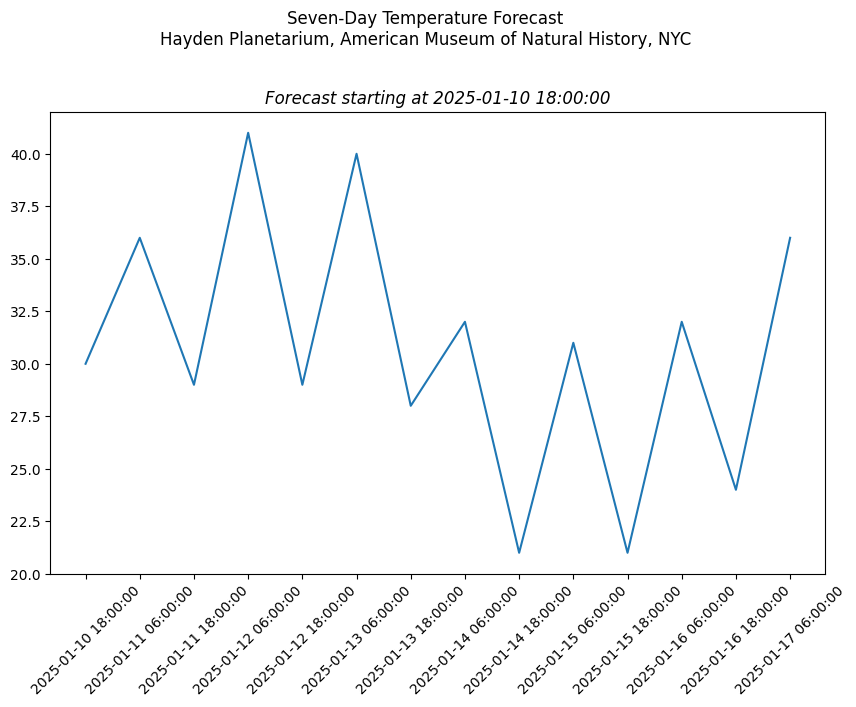

In [220]:
temperatures = [forecast[i]['temperature'] for i in forecast]
times = [
    datetime.fromisoformat(forecast[i]['startTime'].replace("Z", "")).strftime('%Y-%m-%d %H:%M:%S') 
    for i in range(len(forecast))
]

# temperatures
# times

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(times, temperatures)

plt.suptitle('Seven-Day Temperature Forecast\nHayden Planetarium, American Museum of Natural History, NYC', y=1.05)
plt.title(f'Forecast starting at {times[0]}', fontstyle='italic', y=1)
plt.xticks(rotation=45)

plt.show()

Make figure showing seven-day forecast

Then make dagster portion

## NCEI Data

Read NCEI token from text file:

In [70]:
with open('ncei_token.txt', 'r') as file:
    token = file.read().strip()

Pass token to the `NCEIBot`:

In [9]:
ncei = NCEIBot(token, cache_name='ncei_cache')

# find datasets related to precipitation
datasets = ncei.get_datasets()
print(datasets.to_dataframe())

            id  ...           retrieved
0        GHCND  ... 2025-01-09 22:17:23
1         GSOM  ... 2025-01-09 22:17:23
2         GSOY  ... 2025-01-09 22:17:23
3      NEXRAD2  ... 2025-01-09 22:17:23
4      NEXRAD3  ... 2025-01-09 22:17:23
5   NORMAL_ANN  ... 2025-01-09 22:17:23
6   NORMAL_DLY  ... 2025-01-09 22:17:23
7   NORMAL_HLY  ... 2025-01-09 22:17:23
8   NORMAL_MLY  ... 2025-01-09 22:17:23
9    PRECIP_15  ... 2025-01-09 22:17:23
10  PRECIP_HLY  ... 2025-01-09 22:17:23

[11 rows x 8 columns]


Lookup all the stations in the [Global Historical Climatology Network daily (GHCNd)](https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily):

In [ ]:
# fetch file from URL
url_dict = {
    'stations': 'https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt',
    'inventory': 'https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-inventory.txt',
    'countries': 'https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-countries.txt'
}

columns = {
    'stations': ['station_id', 'latitude', 'longitude', 'elevation', 'description', 'flag', 'gsn', 'station_name'],
    'inventory': ['station_id', 'latitude', 'longitude', 'measurement', 'start_year', 'end_year'],
    
}

for name, url in url_dict:

    response = requests.get(url)

    # check if the request was successful
    if response.status_code == 200:
        # read the content of the file into a pandas DataFrame
        data = response.text
        
        # try reading the file as a fixed-width formatted file
        df = pd.read_fwf(StringIO(data), header=None)

        # assign the appropriate column names
        df.columns = ['station_id', 
                    'latitude', 
                    'longitude', 
                    'elevation', 
                    'description',
                    'flag', 
                    'gsn', 
                    'station_name']
        
        # convert to polars
        stations = pl.from_pandas(df)
        print(stations)
    else:
        print(f"Failed to retrieve data. Status code: {response.status_code}")

shape: (128_025, 8)
┌─────────────┬──────────┬───────────┬───────────┬────────────────────┬──────┬──────┬──────────────┐
│ station_id  ┆ latitude ┆ longitude ┆ elevation ┆ description        ┆ flag ┆ gsn  ┆ station_name │
│ ---         ┆ ---      ┆ ---       ┆ ---       ┆ ---                ┆ ---  ┆ ---  ┆ ---          │
│ str         ┆ f64      ┆ f64       ┆ f64       ┆ str                ┆ str  ┆ str  ┆ f64          │
╞═════════════╪══════════╪═══════════╪═══════════╪════════════════════╪══════╪══════╪══════════════╡
│ ACW00011604 ┆ 17.1167  ┆ -61.7833  ┆ 10.1      ┆ ST JOHNS COOLIDGE  ┆ null ┆ null ┆ null         │
│             ┆          ┆           ┆           ┆ FLD                ┆      ┆      ┆              │
│ ACW00011647 ┆ 17.1333  ┆ -61.7833  ┆ 19.2      ┆ ST JOHNS           ┆ null ┆ null ┆ null         │
│ AE000041196 ┆ 25.333   ┆ 55.517    ┆ 34.0      ┆ SHARJAH INTER.     ┆ null ┆ GSN  ┆ 41196.0      │
│             ┆          ┆           ┆           ┆ AIRP               ┆

Also read in the inventory and country code tables, found at the same location as the station list:

In [58]:
# define the file path
file_path = 'data/ghcnd-stations.txt'

# initialize an empty list to store the processed rows
rows = []

# open the file and process each line
with open(file_path, 'r') as file:
    for line in file:
        # clean up the line (normalize whitespaces)
        cleaned_line = re.sub(r'\s+', ' ', line.strip())
        
        # split the cleaned line into columns (space-separated)
        rows.append(cleaned_line.split(' '))

# convert the list of rows into a pandas DataFrame
df = pd.DataFrame(rows, columns=['station_id', 'latitude', 'longitude', 'elevation', 
                                  'us_state', 'location_name', 
                                  'flag', 'gsn', 'station_name'])
df.head()

ValueError: 9 columns passed, passed data had 14 columns

In [ ]:
# fetch the file from the URL
url = 'https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt'
response = requests.get(url)

# check if the request was successful
if response.status_code == 200:
    # read the content of the file into a pandas DataFrame
    data = response.text
    df = pd.read_fwf(StringIO(data), header=None)
    
    # Display the number of columns and the first few rows to understand its structure
    print(f"Number of columns: {df.shape[1]}")
    print(df.head())
else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")

Number of columns: 8
             0        1        2  ...    5    6        7
0  ACW00011604  17.1167 -61.7833  ...  NaN  NaN      NaN
1  ACW00011647  17.1333 -61.7833  ...  NaN  NaN      NaN
2  AE000041196  25.3330  55.5170  ...  NaN  GSN  41196.0
3  AEM00041194  25.2550  55.3640  ...  NaN  NaN  41194.0
4  AEM00041217  24.4330  54.6510  ...  NaN  NaN  41217.0

[5 rows x 8 columns]


In [51]:
# Fetch file from the URL
url = 'https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt'
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Normalize whitespace and handle the data
    cleaned_data = [re.sub(r'\s+', ' ', line.strip()) for line in response.text.splitlines()]

    # Join the cleaned lines into a single string
    cleaned_data_str = '\n'.join(cleaned_data)

    # Read the cleaned data into a Polars DataFrame
    df_polars = pl.read_csv(cleaned_data_str, 
                            has_header=False,
                            separator=' ',
                            truncate_ragged_lines=True)

    # Assign column names
    df_polars.columns = ['station_id', 'latitude', 'longitude', 'elevation', 
                         'location_name', 'flag', 'gsn', 'station_name']

    # Display the first few rows
    print(df_polars.head())
else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")

ComputeError: expected at least 1 source

Also read in the inventory and country code tables, found at the same location as the station list:

In [ ]:
# fetch file from URL
url = 'https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt'
response = requests.get(url)

# check if the request was successful
if response.status_code == 200:
    # read the content of the file into a pandas DataFrame
    data = response.text
    df = pd.read_fwf(StringIO(data), header=None)
    
    # assign column names
    df.columns = ['station_id', 
                  'latitude', 
                  'longitude', 
                  'elevation', 
                  'location_name', 
                  'flag', 
                  'gsn', 
                  'station_name']
    
    # save to polars and 
    # display the first few rows
    df = pl.from_pandas(df)
    print(df.head())
else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")
'https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-inventory.txt'

In [34]:
df.head()

,station_id,latitude,longitude,elevation,location_name,flag,station_name,other
0,ACW00011604,17.1167,-61.7833,10.1,ST JOHNS COOLIDGE FLD,NaN,NaN,NaN
1,ACW00011647,17.1333,-61.7833,19.2,ST JOHNS,NaN,NaN,NaN
2,AE000041196,25.3330,55.5170,34.0,SHARJAH INTER. AIRP,NaN,GSN,41196.0
3,AEM00041194,25.2550,55.3640,10.4,DUBAI INTL,NaN,NaN,41194.0
4,AEM00041217,24.4330,54.6510,26.8,ABU DHABI INTL,NaN,NaN,41217.0


In [37]:
len(df['station_name'].unique())

2

In [12]:
# Define date range and parameters
dataset_id = "GHCND"
datatype_ids = ["PRCP"]  # Precipitation data type
start_date = date(2024, 1, 1)
end_date = date(2024, 12, 31)

# Retrieve all stations in a location
stations = ncei.get_stations(
    datasetid=dataset_id,
    datatypeid=datatype_ids,
    locationid="FIPS:06",  # Location code for California
    startdate=start_date,
    enddate=end_date,
)

# Select a station with good data coverage
station = sorted(stations.values(), key=lambda s: -int(s["datacoverage"]))[0]

# Retrieve precipitation data for the selected station
response = ncei.get_data(
    datasetid=dataset_id,
    stationid=station["id"],
    datatypeid=datatype_ids,
    startdate=start_date,
    enddate=end_date,
)

# Convert to DataFrame for easier analysis
df = response.to_dataframe()
print(df)

No lookup list found for stations


               station  ...           retrieved
0    GHCND:US1CACC0001  ... 2025-01-09 22:34:14
1    GHCND:US1CACC0001  ... 2025-01-09 22:34:14
2    GHCND:US1CACC0001  ... 2025-01-09 22:34:14
3    GHCND:US1CACC0001  ... 2025-01-09 22:34:14
4    GHCND:US1CACC0001  ... 2025-01-09 22:34:14
..                 ...  ...                 ...
361  GHCND:US1CACC0001  ... 2025-01-09 22:34:14
362  GHCND:US1CACC0001  ... 2025-01-09 22:34:14
363  GHCND:US1CACC0001  ... 2025-01-09 22:34:14
364  GHCND:US1CACC0001  ... 2025-01-09 22:34:14
365  GHCND:US1CACC0001  ... 2025-01-09 22:34:14

[366 rows x 7 columns]


In [13]:
df

,station,date,datatype,attributes,value,url,retrieved
0,GHCND:US1CACC0001,2024-01-01,PRCP,",,N,0700",3.8,https://www.ncdc.noaa.gov/cdo-web/api/v2/data?...,2025-01-09 22:34:14
1,GHCND:US1CACC0001,2024-01-02,PRCP,",,N,0700",0.0,https://www.ncdc.noaa.gov/cdo-web/api/v2/data?...,2025-01-09 22:34:14
2,GHCND:US1CACC0001,2024-01-03,PRCP,",,N,0700",12.7,https://www.ncdc.noaa.gov/cdo-web/api/v2/data?...,2025-01-09 22:34:14
3,GHCND:US1CACC0001,2024-01-04,PRCP,",,N,0700",0.0,https://www.ncdc.noaa.gov/cdo-web/api/v2/data?...,2025-01-09 22:34:14
4,GHCND:US1CACC0001,2024-01-05,PRCP,"T,,N,0700",0.0,https://www.ncdc.noaa.gov/cdo-web/api/v2/data?...,2025-01-09 22:34:14
...,...,...,...,...,...,...,...
361,GHCND:US1CACC0001,2024-12-27,PRCP,",,N,0700",9.1,https://www.ncdc.noaa.gov/cdo-web/api/v2/data?...,2025-01-09 22:34:14
362,GHCND:US1CACC0001,2024-12-28,PRCP,",,N,0700",0.3,https://www.ncdc.noaa.gov/cdo-web/api/v2/data?...,2025-01-09 22:34:14
363,GHCND:US1CACC0001,2024-12-29,PRCP,",,N,0700",1.3,https://www.ncdc.noaa.gov/cdo-web/api/v2/data?...,2025-01-09 22:34:14
364,GHCND:US1CACC0001,2024-12-30,PRCP,",,N,0700",10.9,https://www.ncdc.noaa.gov/cdo-web/api/v2/data?...,2025-01-09 22:34:14


In [15]:
df['station'].value_counts()

station
GHCND:US1CACC0001    366
Name: count, dtype: int64

In [18]:
data_types = ncei.get_data_types()
print(data_types.to_dataframe())

KeyError: 'datacoverage'